# Capstone Two: Modeling

In this step of my capstone, I am going to be assessing different models (and tuning hyperparamteters) in order to find the best model I can. 

1. Import the data, libraries. 
2. Run XGBoost 
3. Try a multitude of other algorithms

## 1. Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance 

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error

import time
import os
from library.sb_utils import save_file

In [2]:
df = pd.read_csv('./data/feature_engineered/df_feature_engineered.csv')
test = pd.read_csv('./data/clean/clean_test.csv').set_index('ID') # retain the ID data by setting it to the index

In [3]:
df.head()

,date_block_num,shop_id,item_id,item_cnt_month,revenue,item_monthly_avg_price,num_holiday_month,num_weekend_days,month,days,...,date_shop_avg_item_cnt_lag_3,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_cat_avg_item_cnt_lag_2,date_cat_avg_item_cnt_lag_3,date_cat_avg_item_cnt_lag_12,date_shop_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_2,date_shop_cat_avg_item_cnt_lag_3,date_shop_cat_avg_item_cnt_lag_12
0,12,2,27,0.0,0.0,0.0,10.0,8.0,0,31,...,0.08905,0.1412,1.0820,0.7650,0.9120,0.835,0.95560,0.57130,0.68600,0.4850
1,12,2,30,0.0,0.0,0.0,10.0,8.0,0,31,...,0.08905,0.0000,0.2915,0.2449,0.2362,0.000,0.04623,0.02293,0.02129,0.0000
2,12,2,31,0.0,0.0,0.0,10.0,8.0,0,31,...,0.08905,0.0000,0.2328,0.1831,0.1708,0.000,0.05945,0.04680,0.03293,0.0000
3,12,2,32,1.0,119.0,119.0,10.0,8.0,0,31,...,0.08905,0.1412,0.2915,0.2449,0.2362,0.294,0.04623,0.02293,0.02129,0.0731
4,12,2,33,1.0,199.0,199.0,10.0,8.0,0,31,...,0.08905,0.1412,0.2328,0.1831,0.1708,0.196,0.05945,0.04680,0.03293,0.0767


In [4]:
df.isna().sum()

date_block_num                       0
shop_id                              0
item_id                              0
item_cnt_month                       0
revenue                              0
item_monthly_avg_price               0
num_holiday_month                    0
num_weekend_days                     0
month                                0
days                                 0
item_category_id                     0
item_category_name                   0
group_name                           0
group_id                             0
item_first_month_sold                0
item_months_since_last_sale          0
date_item_avg_item_cnt_lag_1         0
date_item_avg_item_cnt_lag_2         0
date_item_avg_item_cnt_lag_3         0
date_item_avg_item_cnt_lag_12        0
date_shop_avg_item_cnt_lag_1         0
date_shop_avg_item_cnt_lag_2         0
date_shop_avg_item_cnt_lag_3         0
date_shop_avg_item_cnt_lag_12        0
date_cat_avg_item_cnt_lag_1          0
date_cat_avg_item_cnt_lag

In [5]:
df.dtypes

date_block_num                         int64
shop_id                                int64
item_id                                int64
item_cnt_month                       float64
revenue                              float64
item_monthly_avg_price               float64
num_holiday_month                    float64
num_weekend_days                     float64
month                                  int64
days                                   int64
item_category_id                       int64
item_category_name                    object
group_name                            object
group_id                               int64
item_first_month_sold                  int64
item_months_since_last_sale            int64
date_item_avg_item_cnt_lag_1         float64
date_item_avg_item_cnt_lag_2         float64
date_item_avg_item_cnt_lag_3         float64
date_item_avg_item_cnt_lag_12        float64
date_shop_avg_item_cnt_lag_1         float64
date_shop_avg_item_cnt_lag_2         float64
date_shop_

## 2. Untuned Benchmark

In [6]:
X_train = df[df.date_block_num < 33].drop(['item_cnt_month','item_category_name', 'group_name'], axis=1)
y_train = df[df.date_block_num < 33]['item_cnt_month']
X_valid = df[df.date_block_num == 33].drop(['item_cnt_month','item_category_name', 'group_name'], axis=1)
y_valid = df[df.date_block_num == 33]['item_cnt_month']
X_test = df[df.date_block_num == 34].drop(['item_cnt_month','item_category_name', 'group_name'], axis=1)

In [7]:
model = xgb.XGBRegressor(tree_method='gpu_hist') #if you don't have a gpu and want to run, simply remove this parameter

ts = time.time()

model.fit(X_train, y_train, eval_metric="rmse", eval_set=[(X_train, y_train), (X_valid, y_valid)], verbose=True)

print(time.time()-ts, "seconds", (time.time()-ts)/60.0,"minutes")

[0]	validation_0-rmse:0.88703	validation_1-rmse:0.85872
[1]	validation_0-rmse:0.66770	validation_1-rmse:0.64851
[2]	validation_0-rmse:0.52163	validation_1-rmse:0.51505
[3]	validation_0-rmse:0.42751	validation_1-rmse:0.43295
[4]	validation_0-rmse:0.36861	validation_1-rmse:0.38299
[5]	validation_0-rmse:0.32997	validation_1-rmse:0.35354
[6]	validation_0-rmse:0.30738	validation_1-rmse:0.33754
[7]	validation_0-rmse:0.29352	validation_1-rmse:0.33125
[8]	validation_0-rmse:0.28432	validation_1-rmse:0.32773
[9]	validation_0-rmse:0.27826	validation_1-rmse:0.32422
[10]	validation_0-rmse:0.27481	validation_1-rmse:0.32291
[11]	validation_0-rmse:0.27025	validation_1-rmse:0.32061
[12]	validation_0-rmse:0.26608	validation_1-rmse:0.31797
[13]	validation_0-rmse:0.26492	validation_1-rmse:0.31744
[14]	validation_0-rmse:0.26213	validation_1-rmse:0.31708
[15]	validation_0-rmse:0.26058	validation_1-rmse:0.31694
[16]	validation_0-rmse:0.26000	validation_1-rmse:0.31633
[17]	validation_0-rmse:0.25907	validation

In [8]:
#Does rounding help? 
y_valid_pred = model.predict(X_valid).clip(0,20)
y_valid_pred_rounded = [round(value) for value in y_valid_pred]

In [9]:
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error

r2 = r2_score(y_valid, y_valid_pred)
print("R-squared score:",(r2))
r2 = r2_score(y_valid, y_valid_pred_rounded)
print("R-squared score (rounded prediction):",(r2))

print("")

mse = mean_squared_error(y_valid, y_valid_pred)
print("Mean Squared Error:",(mse))
mse = mean_squared_error(y_valid, y_valid_pred_rounded)
print("Mean Squared Error (rounded prediction):",(mse))

print("")

rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
print("Root mean Squared Error:",(rmse))
rmse = mean_squared_error(y_valid, y_valid_pred_rounded, squared=False)
print("Root mean Squared Error (rounded prediction):",(rmse))

R-squared score: 0.9255745603931576
R-squared score (rounded prediction): 0.9254660470604992

Mean Squared Error: 0.09607190707204073
Mean Squared Error (rounded prediction): 0.09621198125724266

Root mean Squared Error: 0.3099546855139324
Root mean Squared Error (rounded prediction): 0.31018056234593855


The rounded values are better for R-squared but the RMSE is higher, so we will not round. 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

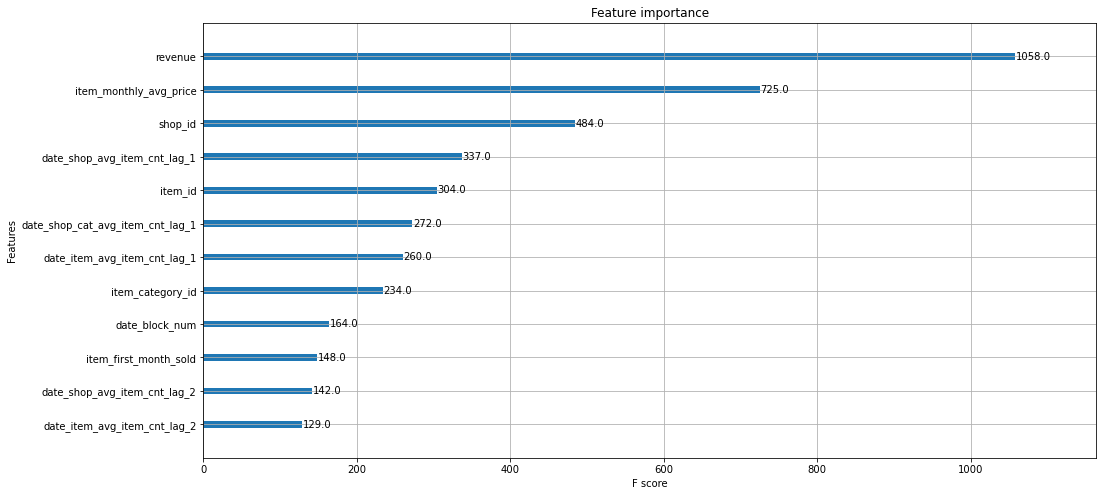

In [10]:
plt.rcParams["figure.figsize"] = (16, 8)
xgb.plot_importance(model, max_num_features=12)

Here we see the most important feaures: revenue of an item, the item monthly average price, and which shop and item ID they have. Seeing these features as important is intuitive! 

In [11]:
y_test = model.predict(X_test).clip(0,20)
# y_test = [round(value) for value in y_test]

In [12]:
untuned_XGB = pd.DataFrame({"ID": test.index, "item_cnt_month": y_test})
datapath = './data/modeling'
save_file(untuned_XGB, 'untuned_xgb.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "./data/modeling\untuned_xgb.csv"


## 3. Other algorithms

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [14]:
# Now that we are introducing cross fold validation and we are not validating, I am going to include the last month. 
X_train = df[df.date_block_num < 34].drop(['item_cnt_month','item_category_name', 'group_name'], axis=1)
y_train = df[df.date_block_num < 34]['item_cnt_month']
X_test = df[df.date_block_num == 34].drop(['item_cnt_month','item_category_name', 'group_name'], axis=1)

In [15]:
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
#pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
#pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))
pipelines.append(('UnscaledXGB', Pipeline([('XGB', xgb.XGBRegressor(tree_method='gpu_hist'))])))
pipelines.append(('ScaledXGB', Pipeline([('Scaler', StandardScaler()),('XGB', xgb.XGBRegressor(tree_method='gpu_hist'))])))

In [16]:
results = []
names = []
for name, model in pipelines:
    ts = time.time()
    kfold = KFold(n_splits=5)#, random_state=42
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    print(time.time()-ts, "seconds", (time.time()-ts)/60.0,"minutes")

ScaledLR: -0.917796 (0.076413)
42.26550769805908 seconds 0.7044251283009847 minutes
ScaledLASSO: -1.182766 (0.093565)
27.565963983535767 seconds 0.45943273305892945 minutes
ScaledEN: -1.161050 (0.094933)
28.183366060256958 seconds 0.4697227676709493 minutes
ScaledCART: -0.066854 (0.012705)
130.8963806629181 seconds 2.181606344381968 minutes
UnscaledXGB: -0.279887 (0.048419)
35.98086881637573 seconds 0.5996811469395955 minutes
ScaledXGB: -0.279887 (0.048419)
50.94003891944885 seconds 0.8490006486574809 minutes


In [17]:
model = DecisionTreeRegressor()

ts = time.time()

model.fit(X_train, y_train)

print(time.time()-ts, "seconds", (time.time()-ts)/60.0,"minutes")

30.018590211868286 seconds 0.5003098368644714 minutes


In [18]:
X_test.isna().sum()

date_block_num                       0
shop_id                              0
item_id                              0
revenue                              0
item_monthly_avg_price               0
num_holiday_month                    0
num_weekend_days                     0
month                                0
days                                 0
item_category_id                     0
group_id                             0
item_first_month_sold                0
item_months_since_last_sale          0
date_item_avg_item_cnt_lag_1         0
date_item_avg_item_cnt_lag_2         0
date_item_avg_item_cnt_lag_3         0
date_item_avg_item_cnt_lag_12        0
date_shop_avg_item_cnt_lag_1         0
date_shop_avg_item_cnt_lag_2         0
date_shop_avg_item_cnt_lag_3         0
date_shop_avg_item_cnt_lag_12        0
date_cat_avg_item_cnt_lag_1          0
date_cat_avg_item_cnt_lag_2          0
date_cat_avg_item_cnt_lag_3          0
date_cat_avg_item_cnt_lag_12         0
date_shop_cat_avg_item_cn

In [19]:
y_test = model.predict(X_test).clip(0,20)

In [20]:
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error

r2 = r2_score(y_valid, y_valid_pred)
print("R-squared score:",(r2))

print("")

mse = mean_squared_error(y_valid, y_valid_pred)
print("Mean Squared Error:",(mse))
mse = mean_squared_error(y_valid, y_valid_pred_rounded)
print("Mean Squared Error (rounded prediction):",(mse))

print("")

rmse = mean_squared_error(y_valid, y_valid_pred, squared=False)
print("Root mean Squared Error:",(rmse))
rmse = mean_squared_error(y_valid, y_valid_pred_rounded, squared=False)
print("Root mean Squared Error (rounded prediction):",(rmse))

R-squared score: 0.9255745603931576

Mean Squared Error: 0.09607190707204073
Mean Squared Error (rounded prediction): 0.09621198125724266

Root mean Squared Error: 0.3099546855139324
Root mean Squared Error (rounded prediction): 0.31018056234593855


In [21]:
untuned_CART = pd.DataFrame({"ID": test.index, "item_cnt_month": y_test})
datapath = './data/modeling'
save_file(untuned_CART, 'untuned_CART.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "./data/modeling\untuned_CART.csv"


From this we can see that the best is Scaled CART. Let's play with the hyperparameters and see if we can get even better scores. 

# TODO
Hyperparameter tuning, more exploration